In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
comp_df = pd.read_csv('./drive/MyDrive/졸업논문/data/고양이/cat_label.csv')
print('Training set: {}'.format(comp_df.shape[0]))

Training set: 90079


In [4]:
comp_df['label'] = LabelEncoder().fit_transform(comp_df.breed)

dict_df = comp_df[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
index_to_breed = dict_df.to_dict()['breed']

In [5]:
!mkdir 'cat_train'

In [ ]:
!unzip /content/drive/MyDrive/졸업논문/data/고양이/cat_train.zip -d /content/cat_train/

In [7]:
train_dir = './cat_train'
comp_df.id = comp_df.id.apply(lambda x:train_dir+'/'+x)
comp_df.pop('breed')

0        staffordshire_bullterrier
1                       schipperke
2                         cardigan
3                       schipperke
4                 lakeland_terrier
                   ...            
90074                   schipperke
90075           norwegian_elkhound
90076               french_bulldog
90077               english_setter
90078                      samoyed
Name: breed, Length: 90079, dtype: object

(199, 300, 3)


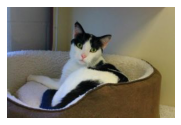

(198, 300, 3)


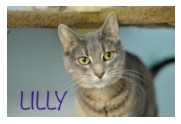

(358, 300, 3)


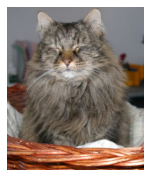

(225, 300, 3)


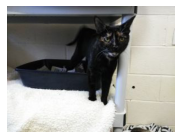

In [8]:
def show_images(df,img_num):
    sample = df.sample(img_num)
    paths = sample.id.tolist()
    for path in paths:
        plt.figure(figsize=(3,3))
        img = plt.imread(path)
        print(img.shape)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
show_images(comp_df,4)

In [9]:
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

class img_dataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0]).convert('RGB')
        #x = Image.open(self.dataframe.iloc[index,0])
        
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,1]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [10]:
train_transformer = transforms.Compose([transforms.CenterCrop(224),
                                        #transforms.RandomRotation(15),
                                        #transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [17]:
def print_epoch_result(train_loss,val_loss,val_acc):
    print('loss: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              val_loss,
                                                                              val_acc))
def train_model(model, cost_function, optimizer,num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    best_valid_loss = 1000
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            train_sub_losses.append(loss.item())

            
        # Validation
        val_sub_losses = []
        model.eval()
        with torch.no_grad():
          correct = 0
          total = 0
          for x,y in val_loader:
            
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            _, predicted = torch.max(y_hat.data, 1)
            total += len(y)
            correct += (predicted == y).sum().item()
            
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        val_acc.append(correct/total)

        if best_valid_loss > np.mean(val_sub_losses):
          torch.save(model.state_dict(), './copy_model.pth')
          best_valid_loss = np.mean(val_sub_losses)
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),np.mean(val_sub_losses),correct/total)

        scheduler.step(metrics=np.mean(val_sub_losses))
        
    print('Finish Training.')
    return train_losses, val_losses, val_acc

In [12]:
# Setting up gpu
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [13]:
# Parameters for dataset
training_samples = comp_df.shape[0] # Use small number first to test whether the model is doing well, then change back to full dataset
test_size=0.2
batch_size = 64

# Reduce the number of samples
sample_df = comp_df.sample(training_samples)

# Split the comp_df into training set and validation set
x_train,x_val,_,_ = train_test_split(sample_df,sample_df,test_size=test_size)

# Create dataloaders form datasets
train_set = img_dataset(x_train, transform=train_transformer)
val_set = img_dataset(x_val, transform=val_transformer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

# How many images in training set and val set?
print('Training set: {}, Validation set: {}'.format(x_train.shape[0],x_val.shape[0]))

Training set: 72063, Validation set: 18016


In [14]:
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_final = net(base_model=res, base_out_features=res.fc.out_features, num_classes=80)
model_final = model_final.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [20]:
# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_final.parameters() if param.requires_grad], lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,patience=3, factor=0.9, verbose=True)
# Learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.1)

# Epoch 
EPOCHS = 30

In [21]:
# Start Training
train_losses, val_losses, val_acc = train_model(model=model_final, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

---------------
Start training 1/30
---------------
loss: 1.576, val_loss: 1.537, val_acc: 0.541
---------------
Start training 2/30
---------------
loss: 1.525, val_loss: 1.509, val_acc: 0.546
---------------
Start training 3/30
---------------
loss: 1.504, val_loss: 1.509, val_acc: 0.548
---------------
Start training 4/30
---------------
loss: 1.485, val_loss: 1.505, val_acc: 0.550
---------------
Start training 5/30
---------------
loss: 1.472, val_loss: 1.496, val_acc: 0.556
---------------
Start training 6/30
---------------
loss: 1.454, val_loss: 1.506, val_acc: 0.550
---------------
Start training 7/30
---------------
loss: 1.443, val_loss: 1.502, val_acc: 0.551
---------------
Start training 8/30
---------------
loss: 1.433, val_loss: 1.500, val_acc: 0.553
---------------
Start training 9/30
---------------
loss: 1.425, val_loss: 1.484, val_acc: 0.554
---------------
Start training 10/30
---------------
loss: 1.413, val_loss: 1.493, val_acc: 0.552
---------------
Start trainin